In [1]:
import numpy as np
data = np.load("/content/candidate_dataset.npz")

X_train = data["x_train"]
y_train = data["y_train"]

X_val   = data["x_val"]
y_val   = data["y_val"]
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7007, 28, 28, 3) (7007, 1)
(1003, 28, 28, 3) (1003, 1)


In [2]:
print(data.files)

['x_train', 'y_train', 'x_val', 'y_val']


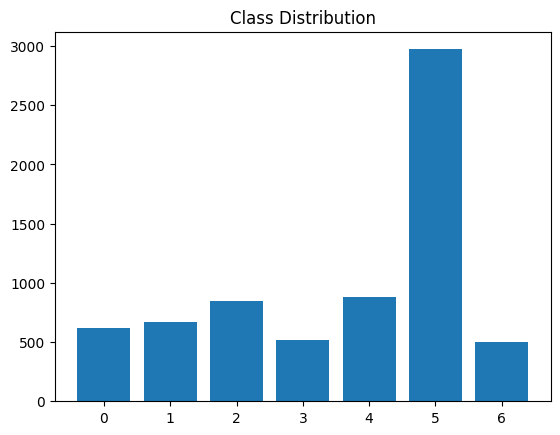

{0: np.int64(616), 1: np.int64(670), 2: np.int64(845), 3: np.int64(520), 4: np.int64(884), 5: np.int64(2973), 6: np.int64(499)}


In [3]:
import matplotlib.pyplot as plt

counts = np.bincount(y_train.flatten())

plt.bar(range(len(counts)), counts)
plt.title("Class Distribution")
plt.show()

print(dict(enumerate(counts)))

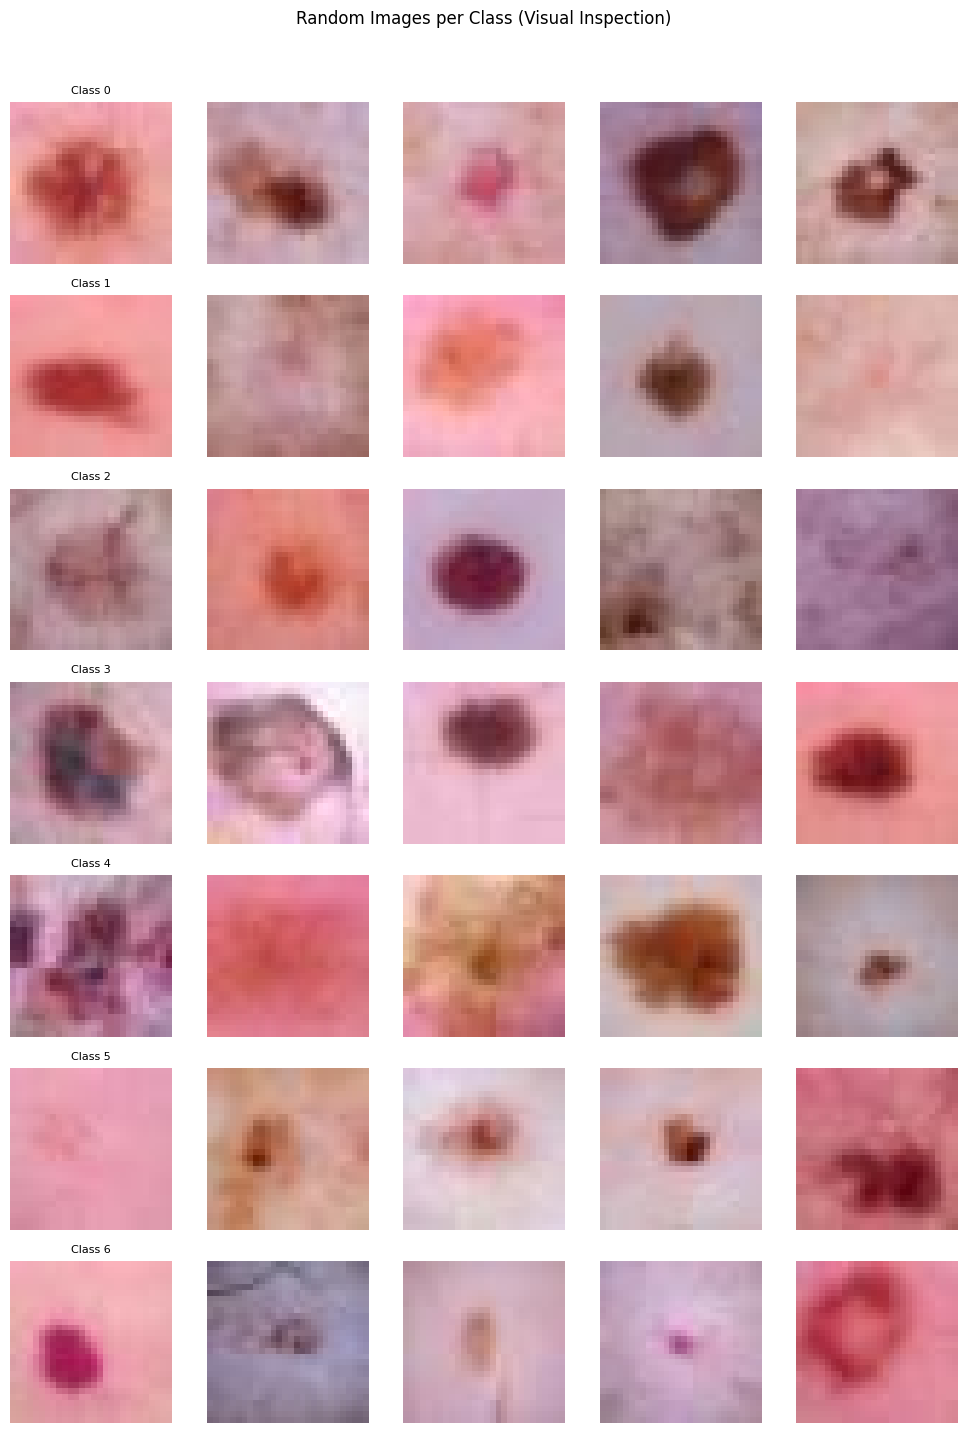

In [4]:
num_classes = len(counts)
class_names = [f"Class {i}" for i in range(num_classes)]
samples_per_class = 5

plt.figure(figsize=(samples_per_class * 2, num_classes * 2))

for cls in range(num_classes):
    idxs = np.where(y_train == cls)[0]
    if len(idxs) == 0:
        continue

    n_show = min(samples_per_class, len(idxs))
    chosen = np.random.choice(idxs, n_show, replace=False)

    for j, idx in enumerate(chosen):
        plot_idx = cls * samples_per_class + j + 1
        ax = plt.subplot(num_classes, samples_per_class, plot_idx)
        ax.imshow(X_train[idx])

        if j == 0:
            ax.set_title(class_names[cls], fontsize=8)

        ax.axis("off")

plt.suptitle("Random Images per Class (Visual Inspection)", y=1.02)
plt.tight_layout()
plt.show()

Channel-wise means (R, G, B): [0.763578   0.53720134 0.56135535]
Channel-wise stds  (R, G, B): [0.13618977 0.15401377 0.16870274]


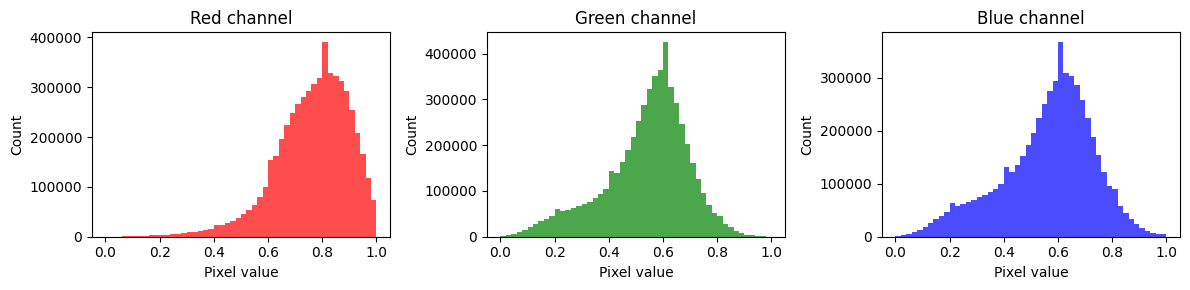

In [5]:
if X_train.dtype != np.float32 and X_train.dtype != np.float64:
    X_train_f = X_train.astype("float32") / 255.0
    X_val_f   = X_val.astype("float32") / 255.0
else:
    X_train_f = X_train
    X_val_f   = X_val

channel_means = X_train_f.mean(axis=(0, 1, 2))
channel_stds  = X_train_f.std(axis=(0, 1, 2))

print("Channel-wise means (R, G, B):", channel_means)
print("Channel-wise stds  (R, G, B):", channel_stds)



r = X_train_f[..., 0].ravel()
g = X_train_f[..., 1].ravel()
b = X_train_f[..., 2].ravel()

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.hist(r, bins=50, color='r', alpha=0.7)
plt.title("Red channel")
plt.xlabel("Pixel value")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
plt.hist(g, bins=50, color='g', alpha=0.7)
plt.title("Green channel")
plt.xlabel("Pixel value")
plt.ylabel("Count")

plt.subplot(1, 3, 3)
plt.hist(b, bins=50, color='b', alpha=0.7)
plt.title("Blue channel")
plt.xlabel("Pixel value")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [6]:
import numpy as np

def oversample_minority(X, y, target_per_class=3000):
    X_new = []
    y_new = []

    classes = np.unique(y)

    for c in classes:
        idx = np.where(y == c)[0]
        X_c = X[idx]
        y_c = y[idx]

        if len(X_c) < target_per_class:
            repeat_factor = int(np.ceil(target_per_class / len(X_c)))
            X_c = np.tile(X_c, (repeat_factor,1,1,1))
            y_c = np.tile(y_c, repeat_factor)

        X_new.append(X_c[:target_per_class])
        y_new.append(y_c[:target_per_class])

    return np.concatenate(X_new), np.concatenate(y_new)


In [7]:
X = data["x_train"]
y = data["y_train"]

X_train, y_train = oversample_minority(
    X,
    y.flatten(),
    target_per_class=1200
)

x_val = data["x_val"]
y_val = data["y_val"]
print(len(x_val))
print(len(y_val))

1003
1003


In [8]:
len(data['y_train'])

7007

data Augmentation

In [9]:
import torchvision.transforms as T

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(25),
    T.RandomAffine(
        degrees=0,
        translate=(0.15,0.15),
        scale=(0.85,1.15)
    ),
    T.ColorJitter(brightness=0.3, contrast=0.3)
])

val_transform = None



In [10]:
from torch.utils.data import Dataset
import torch

class ArrayDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y.flatten()
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = torch.tensor(self.X[idx]/255.0, dtype=torch.float32)
        img = img.permute(2,0,1)
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return img, label


In [11]:
train_dataset = ArrayDataset(X_train, y_train, train_transform)
val_dataset   = ArrayDataset(x_val, y_val, val_transform)


from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels//reduction)
        self.fc2 = nn.Linear(channels//reduction, channels)

    def forward(self, x):
        b,c,h,w = x.shape
        y = x.mean(dim=(2,3))
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        y = y.view(b,c,1,1)
        return x * y


class NoiseRobustCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.se = SEBlock(128)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.se(x)
        x = self.classifier(x)
        return x


In [13]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=7, smoothing=0.1):
        super().__init__()
        self.cls = classes
        self.smoothing = smoothing

    def forward(self, pred, target):
        log_probs = F.log_softmax(pred, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1-self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=1))


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = NoiseRobustCNN().to(device)

criterion = LabelSmoothingLoss(smoothing=0.03)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=5
)

best_acc = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []


for epoch in range(50):

    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred_class = preds.argmax(1)
        correct += (pred_class == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total


    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            preds = model(imgs)
            loss = criterion(preds, labels)

            val_running_loss += loss.item()
            pred_class = preds.argmax(1)
            val_correct += (pred_class == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_acc = val_correct / val_total


    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    print(
        f"Epoch [{epoch+1}/50] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
        )

    scheduler.step(val_acc)

    if  val_acc > best_acc:
        best_acc = val_acc
        checkpoint = {
          "model_state": model.state_dict(),
          "num_classes": 7,
          "scale": 255.0
                      }
        torch.save(checkpoint, "Latest_model.pth")

Epoch [1/50] | Train Loss: 1.9482 | Val Loss: 1.8065 | Train Acc: 0.1706 | Val Acc: 0.4407
Epoch [2/50] | Train Loss: 1.9378 | Val Loss: 1.7827 | Train Acc: 0.1808 | Val Acc: 0.5254
Epoch [3/50] | Train Loss: 1.9315 | Val Loss: 1.7651 | Train Acc: 0.1854 | Val Acc: 0.5573
Epoch [4/50] | Train Loss: 1.9297 | Val Loss: 1.9349 | Train Acc: 0.1955 | Val Acc: 0.3460
Epoch [5/50] | Train Loss: 1.9265 | Val Loss: 1.8285 | Train Acc: 0.1926 | Val Acc: 0.4556
Epoch [6/50] | Train Loss: 1.9203 | Val Loss: 1.7529 | Train Acc: 0.2049 | Val Acc: 0.5105
Epoch [7/50] | Train Loss: 1.9194 | Val Loss: 1.7731 | Train Acc: 0.2035 | Val Acc: 0.5075
Epoch [8/50] | Train Loss: 1.9185 | Val Loss: 1.7334 | Train Acc: 0.2139 | Val Acc: 0.5733
Epoch [9/50] | Train Loss: 1.9170 | Val Loss: 1.7257 | Train Acc: 0.2081 | Val Acc: 0.5204
Epoch [10/50] | Train Loss: 1.9118 | Val Loss: 1.6612 | Train Acc: 0.2158 | Val Acc: 0.6291
Epoch [11/50] | Train Loss: 1.9130 | Val Loss: 1.6748 | Train Acc: 0.2119 | Val Acc: 0.52

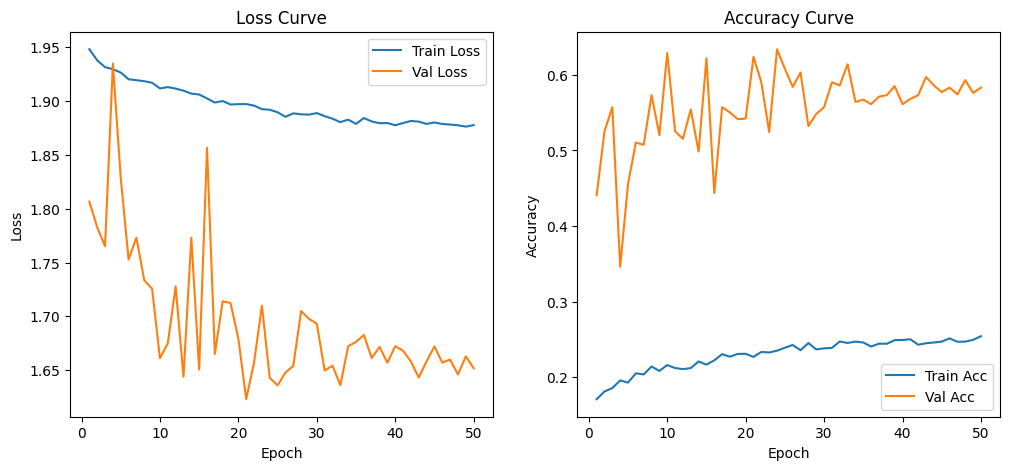

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [16]:
import numpy as np

def classwise_accuracy(model, dataloader, num_classes=7):
    model.eval()

    correct = np.zeros(num_classes)
    total   = np.zeros(num_classes)

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(1)

            for i in range(len(labels)):
                label = labels[i].item()
                pred  = preds[i].item()

                if pred == label:
                    correct[label] += 1
                total[label] += 1

    for c in range(num_classes):
        acc = correct[c] / total[c] if total[c] > 0 else 0
        print(f"Class {c} Accuracy: {acc:.4f}")


In [17]:
classwise_accuracy(model, val_loader)


Class 0 Accuracy: 0.2121
Class 1 Accuracy: 0.4231
Class 2 Accuracy: 0.4000
Class 3 Accuracy: 0.1667
Class 4 Accuracy: 0.6577
Class 5 Accuracy: 0.6364
Class 6 Accuracy: 0.7143


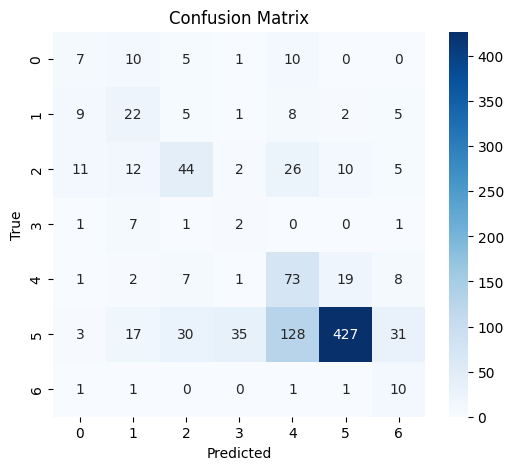

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [19]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=4))


Classification Report:

              precision    recall  f1-score   support

           0     0.2121    0.2121    0.2121        33
           1     0.3099    0.4231    0.3577        52
           2     0.4783    0.4000    0.4356       110
           3     0.0476    0.1667    0.0741        12
           4     0.2967    0.6577    0.4090       111
           5     0.9303    0.6364    0.7558       671
           6     0.1667    0.7143    0.2703        14

    accuracy                         0.5833      1003
   macro avg     0.3488    0.4586    0.3592      1003
weighted avg     0.7336    0.5833    0.6288      1003



In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(model, loader, device):
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(1).cpu().numpy()

            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    return np.array(y_true), np.array(y_pred)


y_true, y_pred = get_predictions(model, val_loader, device)

acc = (y_true == y_pred).mean()
print("\nValidation Accuracy:", acc)


Validation Accuracy: 0.5832502492522432


In [21]:
print("\n===== TP TN FP FN per class =====")

for i in range(len(np.unique(y_true))):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    print(f"\nClass {i}")
    print(f"TP:{TP}  FP:{FP}  FN:{FN}  TN:{TN}")



===== TP TN FP FN per class =====

Class 0
TP:7  FP:26  FN:26  TN:944

Class 1
TP:22  FP:49  FN:30  TN:902

Class 2
TP:44  FP:48  FN:66  TN:845

Class 3
TP:2  FP:40  FN:10  TN:951

Class 4
TP:73  FP:173  FN:38  TN:719

Class 5
TP:427  FP:32  FN:244  TN:300

Class 6
TP:10  FP:50  FN:4  TN:939


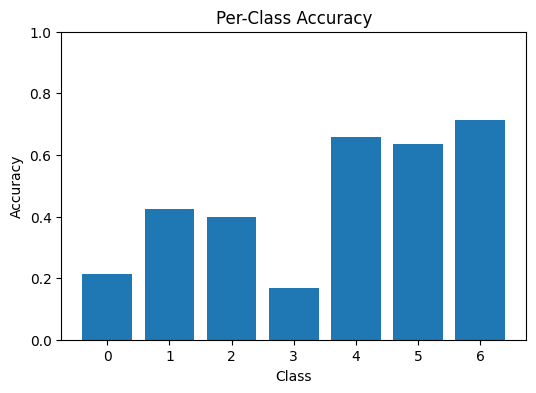

In [22]:
class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6,4))
plt.bar(range(len(class_acc)), class_acc)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.ylim(0,1)
plt.show()


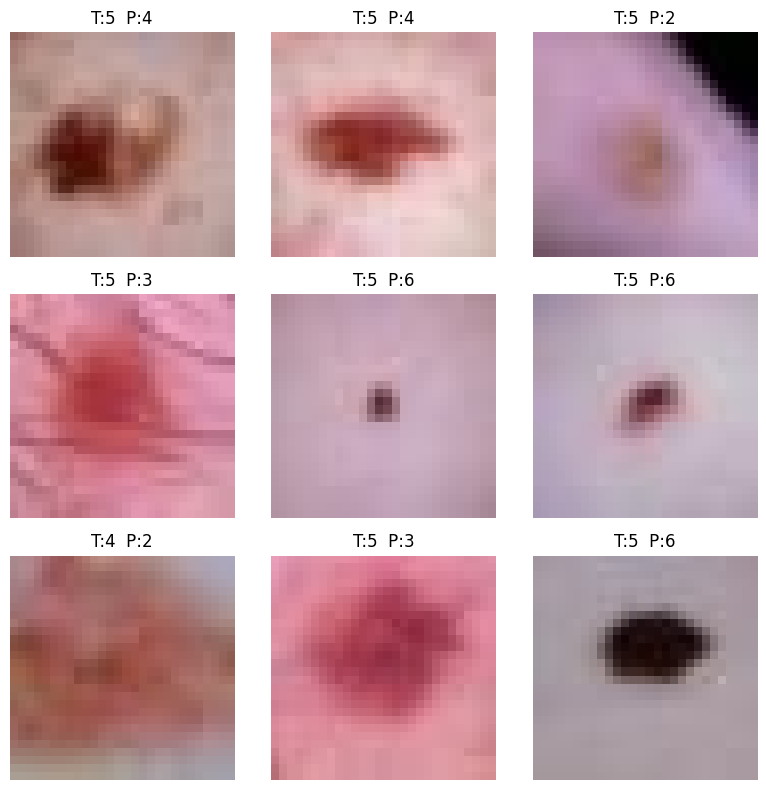

In [23]:
wrong_idx = np.where(y_true != y_pred)[0][:9]

plt.figure(figsize=(8,8))

for i, idx in enumerate(wrong_idx):
    img = x_val[idx]

    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{y_true[idx]}  P:{y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()